# Arbitrary Resolution Ellipsoid Simulation Example

In [1]:
import numpy as np
import pyMACS
from pyMACS.virtualMACS import VirtualMACS
import mcstasscript as ms
useOld=True
macs= VirtualMACS('Resolution_ellipsoid_tio2',cifName='TiO2.cif',useOld=useOld)
macs.sample.formula_weight=80.0 # Made up
numthreads=8

#########################
Old simulations found in /mnt/c/Users/tjh/OneDrive - NIST/GitHub/pyMACS/docs/source/notebooks/Resolution_ellipsoid_tio2/Kidney_simulations/
 
Successfully combined old simulations into /mnt/c/Users/tjh/OneDrive - NIST/GitHub/pyMACS/docs/source/notebooks/Resolution_ellipsoid_tio2/Kidney_simulations/Resolution_ellipsoid_tio2_total.csv

Data matrix instantiated and ready to use.
#########################


### In this notebook, we will demonstrate the simulation of a single resolution ellipsoid at the (-1.3,-1.3,-0.5) , $\Delta$E=3.5 meV position

## Single Crystal SQW4 process. 

pyMACS includes an experimental UNION process, the Sqw4_process. It will work out of the box, and behaves very similarly to the single_crystal_process. It is essentially a port of Single_crystal_inelastic.comp by Duc Le. 

In [2]:
import os
import shutil
#To use the sqw4 process, it requires the copying of the component into the current directory. 
if not os.path.exists("Sqw4_process.comp"):
    shutil.copy(macs.instr_template_dir+"Sqw4_process.comp","Sqw4_process.comp")


In [3]:
#Going to make our sample artifically big to increase count rate. 
macs.sample.sample_widx=0.01
macs.sample.sample_widy=0.01
macs.sample.sample_widz=0.01

macs.monochromator.Ei = 5.0 #This will change
macs.monochromator.Ef = 5.0
macs.sample.cif2lau()

#Sample is aligned in the HHL plane
macs.sample.orient_u=[1,1,0]
macs.sample.orient_v=[0,0,1]
macs.sample.project_sample_realspace()

scattering_def = ms.McStas_instr("scattering_definition",checks=False)
inc_scatter = scattering_def.add_component("inc_scatter","Incoherent_process")
inc_scatter.sigma=macs.sample.sigma_inc
inc_scatter.unit_cell_volume = macs.sample.cell_vol
inc_scatter.packing_factor = 1
inc_scatter.interact_fraction=0.25
inc_scatter.set_AT([0,0,0])

#Single crystal process. 
crystal_scatter = scattering_def.add_component("crystal_scatter","Single_crystal_process")
crystal_scatter.delta_d_d=0.005
crystal_scatter.mosaic = 30.0
#Projections of lattice vectors onto lab frame is handled by the previous helper process.
labproj = macs.sample.labframe_mat
crystal_scatter.ax = labproj[0,0]
crystal_scatter.ay = labproj[0,1]
crystal_scatter.az = labproj[0,2]
crystal_scatter.bx =labproj[1,0]
crystal_scatter.by = labproj[1,1]
crystal_scatter.bz = labproj[1,2]
crystal_scatter.cx = labproj[2,0]
crystal_scatter.cy = labproj[2,1]
crystal_scatter.cz = labproj[2,2]
crystal_scatter.reflections='\"'+"TiO2.lau"+'\"'
crystal_scatter.barns=1
crystal_scatter.packing_factor=1
crystal_scatter.powder=0
crystal_scatter.PG=0
crystal_scatter.interact_fraction=0.25
crystal_scatter.set_AT([0,0,0])
crystal_scatter.set_ROTATED([0,0,0])

#Sample sqw4 processs
sample_sqw4 = scattering_def.add_component("sample_sqw4", "Sqw4_process")
sample_sqw4.sqw = '"tio2_resfunc.sqw4"'
#This file must also be added to the instrument file dependencies to be copied correctly.
macs.file_dependencies="tio2_resfunc.sqw4"
#We are choosing to have the (100) vector along the x-axis
sample_sqw4.ax=labproj[0,0]
sample_sqw4.ay=labproj[0,1]
sample_sqw4.az=labproj[0,2]
sample_sqw4.bx=labproj[1,0]
sample_sqw4.by=labproj[1,1]
sample_sqw4.bz=labproj[1,2]
sample_sqw4.cx=labproj[2,0]
sample_sqw4.cy=labproj[2,1]
sample_sqw4.cz=labproj[2,2]
sample_sqw4.aa=macs.sample.alpha
sample_sqw4.bb=macs.sample.beta
sample_sqw4.cc=macs.sample.gamma
sample_sqw4.barns=1
sample_sqw4.max_stored_ki=1e5
sample_sqw4.max_bad=1e5
sample_sqw4.stored_dTheta = 0.1
sample_sqw4.stored_dkmag = 1e-4
sample_sqw4.recip_cell=0
sample_sqw4.interact_fraction=1
#sample_sqw4.init="'init'"
#sample_sqw4.append_EXTEND("// Remove direct beam\nif(!SCATTERED) ABSORB;")
sample_sqw4.set_AT([0,0,0])
sample_sqw4.set_ROTATED([0,0,0])
crystal_scatter.interact_fraction=0.5

scattering = scattering_def.add_component("TiO2","Union_make_material")
scattering.process_string='"crystal_scatter,inc_scatter,sample_sqw4"'
scattering.my_absorption=macs.sample.rho_abs
scattering.set_AT([0,0,0])

#Now, this pseudo-instrument will be saved as the scattering definition of the sample. 
macs.sample.scattering_def = scattering_def

#Make a second object for the geometry. This particular case replicates the validation experiment for this package.
geo_def = ms.McStas_instr("geometry_definition",checks=False)

sample_cube=geo_def.add_component("sample_cube","Union_box")
sample_cube.xwidth=1.0*macs.sample.sample_widx
sample_cube.yheight=1.0*macs.sample.sample_widy
sample_cube.zdepth=1.0*macs.sample.sample_widz
sample_cube.priority=100
sample_cube.material_string='\"TiO2\"'
sample_cube.number_of_activations="number_of_activations_sample" #Do not change. 
sample_cube.set_AT([0,0,0],RELATIVE='crystal_assembly')
sample_cube.set_ROTATED([0,0,0],RELATIVE='crystal_assembly')

sample_plate = geo_def.add_component("sample_plate","Union_cylinder")
sample_plate.radius=0.006
sample_plate.yheight=0.002
sample_plate.priority=40
sample_plate.material_string='"Al"'
plate_distance = macs.sample.sample_widy+0.002
sample_plate.set_AT([0,plate_distance,0],RELATIVE="target")
sample_plate.set_ROTATED([0,0,0],RELATIVE="target")

sample_plate_rod = geo_def.add_component("sample_plate_rod","Union_cylinder")
sample_plate_rod.radius=0.00125
sample_plate_rod.yheight=0.0633
sample_plate_rod.priority=41
sample_plate_rod.material_string='"Al"'
sample_plate_rod.set_AT([0,plate_distance+0.001+0.031,0], RELATIVE="target")
sample_plate_rod.set_ROTATED([0,0,0],RELATIVE="target")

sample_base = geo_def.add_component("sample_base","Union_cylinder")
sample_base.radius=0.0065
sample_base.yheight=0.013
sample_base.priority=42
sample_base.material_string='\"Al\"'
sample_base.set_AT([0,0.0628,0],RELATIVE="target")
sample_base.set_ROTATED([0,0,0],RELATIVE="target")

sample_base_gap = geo_def.add_component("sample_base_gap","Union_cylinder")
sample_base_gap.radius=0.004
sample_base_gap.yheight=0.009
sample_base_gap.priority=43
sample_base_gap.material_string='"Vacuum"'
sample_base_gap.set_AT([0,0.0668,0], RELATIVE="target")
sample_base_gap.set_ROTATED([0,0,0],RELATIVE="target")

macs.sample.geometry_def = geo_def

 
Conversion of CIF to crystallographical LAU file successful. 


## Perform simulations around the relevant point. 

In [4]:
#Some housekeeping steps needed for simulation
if useOld!=True:
    macs.prepare_expt_directory()
    macs.edit_instr_file()
    macs.compileMonochromator()
    macs.compileInstr()

In [5]:
%matplotlib inline

In [ ]:
macs.kidney.Ef=5.0
macs.monochromator.Ei=5.0
macs.n_mono=1e7
macs.n_sample=2e5
macs.kidney_angle_resolution=0.5
macs.preserve_kidney_scan_files=False
# pyMACS natively supports multithreading through joblib threading.
macs.script_scan(A3_list=np.arange(-40,-20,0.2),Ei_list=np.arange(3.0,4.01,0.05)+macs.monochromator.Ei,num_threads=8,scan_title='_tio2_resolution')

Total Scans:   0%|          | 0/21 [00:00<?, ?it/s]

Ei=8.5 meV:   0%|          | 0/19 [00:00<?, ?it/s]

Ei=8.55 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=8.6 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=8.649999999999999 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=8.7 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=8.75 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=8.799999999999999 meV:   0%|          | 0/19 [00:00<?, ?it/s]

Ei=8.849999999999998 meV:   0%|          | 0/19 [00:00<?, ?it/s]

Ei=8.899999999999999 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=8.95 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=8.999999999999998 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=9.049999999999997 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=9.099999999999998 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=9.149999999999999 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=9.199999999999998 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=9.249999999999996 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=9.299999999999997 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=9.349999999999998 meV:   0%|          | 0/18 [00:00<?, ?it/s]

Ei=9.399999999999997 meV:   0%|          | 0/18 [00:00<?, ?it/s]

interactive(children=(FloatSlider(value=3.5, description='eslice', max=4.0, min=3.0, step=0.05), Output()), _d…

interactive(children=(FloatSlider(value=-0.5, description='Lslice', max=-0.45, min=-0.55, step=0.01), Output()…

<function __main__.plot_hh0slice(Lslice)>

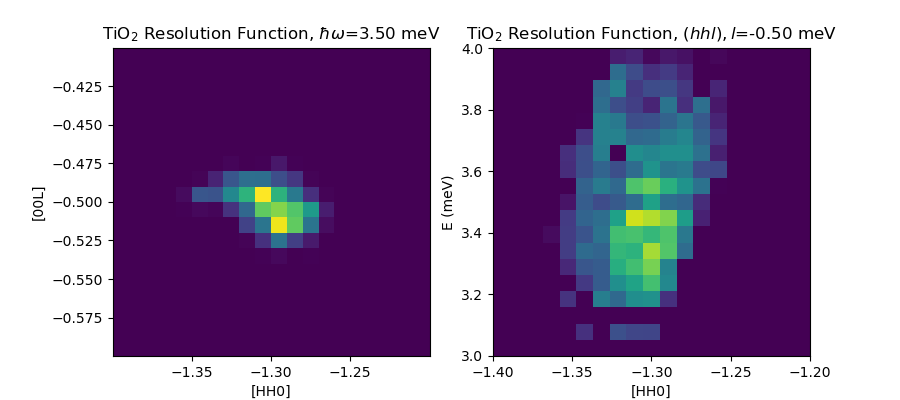

In [36]:
%matplotlib widget
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
macs.data.project_data_QE()
nslice = 20
eslice = 3.5

fig,axs=plt.subplots(1,2,figsize=(9,4))
ax = axs[0]
ax.set_xlabel('[HH0]')
ax.set_ylabel('[00L]')
ax.set_title("TiO2 Resolution, 3.5 meV")

ax2 = axs[1]
ax2.set_xlabel('[HH0]')
ax2.set_ylabel('E (meV)')
ax2.set_title("TiO2 Resolution, $l$=-0.3, 3.5 meV")


def plot_eslice(eslice):
    U,V,I = macs.data.bin_constE_slice(nslice,nslice,[-1.4,-1.2],[-0.6,-0.4],[eslice-0.1,eslice+0.1])
    #U,V,I = macs.data.bin_constE_slice(nslice,nslice,[-2.4,1.2],[-2.6,3.4],[eslice-0.01,eslice+0.01])
    ax.pcolormesh(U,V,I.T,vmin=0,vmax=1.4e4)
    ax.set_title("TiO$_2$ Resolution Function, $\hbar\omega$="+f"{eslice:.2f} meV")

def plot_hh0slice(Lslice):
    U,V,I,Err = macs.data.take_slice([-1.4,-1.2,nslice],[Lslice-0.01,Lslice+0.01],[3.0,4.0,20],which_data='mcstas')
    #U,V,I = macs.data.bin_constE_slice(nslice,nslice,[-2.4,1.2],[-2.6,3.4],[eslice-0.01,eslice+0.01])
    ax2.pcolormesh(U,V,I.T,vmin=0,vmax=5e1)
    ax2.set_title("TiO$_2$ Resolution Function, $(hhl), l$="+f"{Lslice:.2f} meV")
#ax.pcolormesh(U,V,I.T,vmin=0,vmax=5000)
#fig.show()

interact(plot_eslice, eslice = widgets.FloatSlider(value=3.5, min=3.0, max=4.0, step=0.05))
interact(plot_hh0slice, Lslice = widgets.FloatSlider(value=-0.50, min=-0.55, max=-0.45, step=0.01))
